# 

# **Tutorial 3** - scientific Python ecosystem: `xarray`

In this tutorial we will to process and visualize raster data using [`PyGMT`](https://www.pygmt.org)'s integration with [**Xarray**](https://xarray.dev).

-----
This tutorial is part of the AGU2024 annual meeting GMT/PyGMT pre-conference workshop (PREWS9) **Mastering Geospatial Visualizations with GMT/PyGMT**
- Conference: https://agu.confex.com/agu/agu24/meetingapp.cgi/Session/226736
- GitHub: https://github.com/GenericMappingTools/agu24workshop
- Website: https://www.generic-mapping-tools.org/agu24workshop
- Recommended version: PyGMT v0.13.0 with GMT 6.5.0

## What is Xarray?

[Xarray](https://xarray.dev) is an open source project and Python package for working with n-dimensional data using labeled dimensions and coordinates.

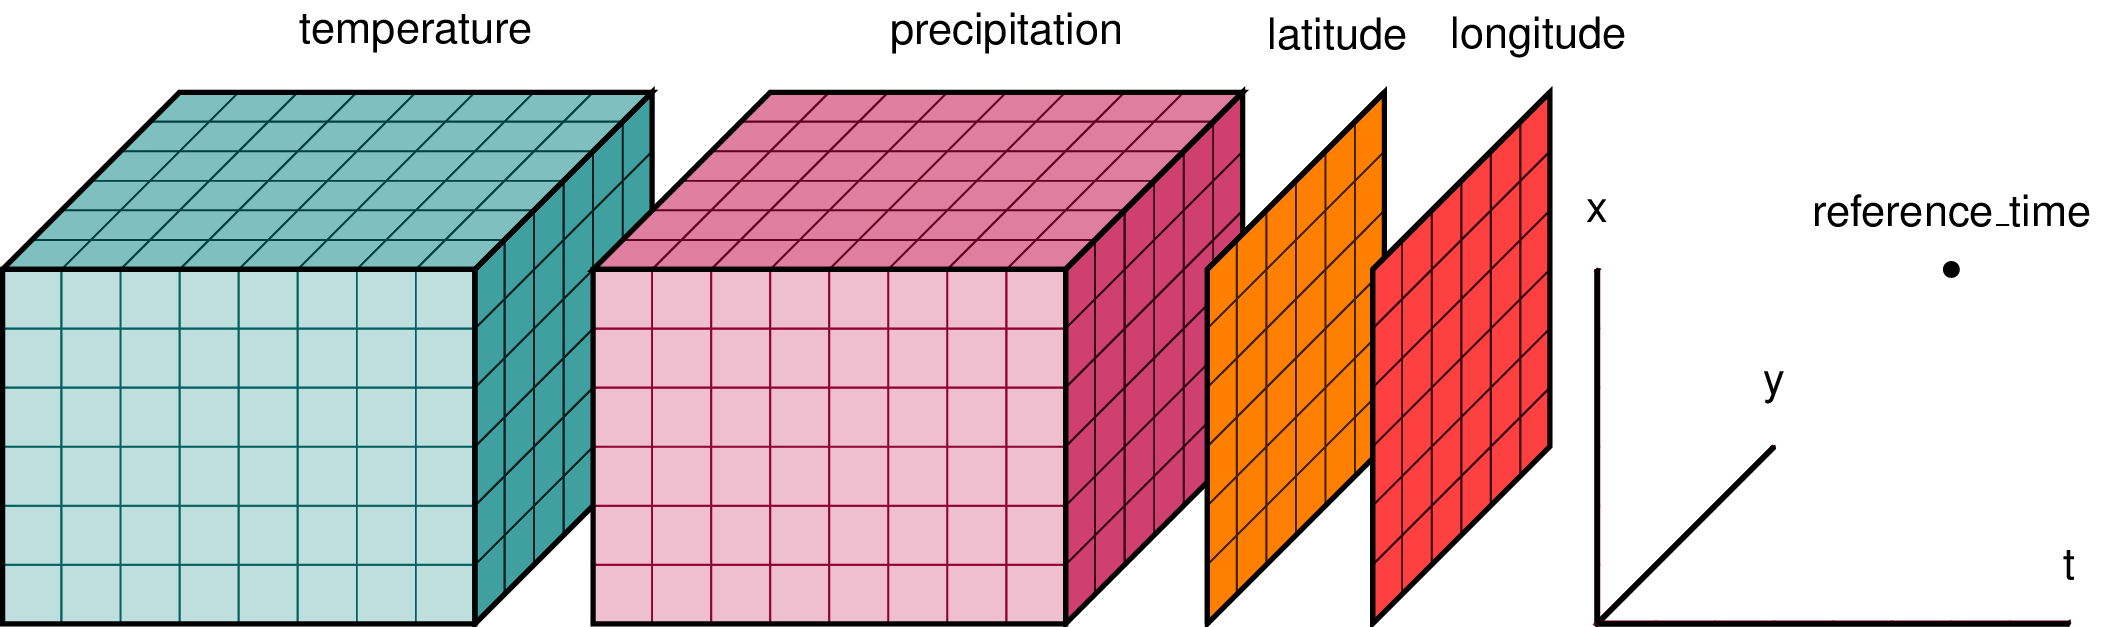

## Why use Xarray with PyGMT

Xarray provides a set of [useful features](https://xarray.dev/#features) for working with multi-dimensional data and unlocks even more functionality through its [rich ecosystem](https://xarray.dev/#ecosystem). Some specific benefits of integrating Xarray and PyGMT include:

- Simplifying the extension of PyGMT functionality to 3-D+ datasets
- Access additional datasets, such as those located on the cloud
- Use out-of-core computing with libraries like Dask
- Interactively visualize by using Xarray, PyGMT, and dashboarding tools like Panel and Bokeh
- Work with both raster and vector data in memory


## Getting started

First we'll import all the modules used throughout the tutorial.

In [1]:
import gcsfs
import pygmt
import xarray as xr

Let's use a PyGMT function to explore an Xarray DataArray. We can use the `load_earth_relief` function to load one of GMT's remote datasets. This will take longer the first time that it's run because GMT downloads the data from the GMT server. We'll specify the server in order to quicken download speeds to Washington, D.C., USA.

In [ ]:
with pygmt.config(GMT_DATA_SERVER="NOAA"):
    grid = pygmt.datasets.load_earth_relief(resolution="01d")
grid

<xarray.DataArray 'z' (lat: 181, lon: 361)> Size: 523kB
array([[ 2865. ,  2865. ,  2865. , ...,  2865. ,  2865. ,  2865. ],
       [ 3088. ,  3087.5,  3087. , ...,  3088.5,  3088. ,  3088. ],
       [ 3100.5,  3100.5,  3101. , ...,  3101.5,  3101. ,  3100.5],
       ...,
       [-3745.5, -3731. , -3723. , ..., -3734. , -3741.5, -3745.5],
       [-2939.5, -2945. , -2950.5, ..., -2895. , -2921. , -2939.5],
       [-3861. , -3861. , -3861. , ..., -3861. , -3861. , -3861. ]])
Coordinates:
  * lat      (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float64 3kB -180.0 -179.0 -178.0 -177.0 ... 178.0 179.0 180.0
Attributes:
    Conventions:       CF-1.7
    title:             SRTM15 Earth Relief v2.6 at 01 arc degree
    history:           
    description:       IGPP Earth relief
    long_name:         elevation (m)
    units:             meters
    vertical_datum:    EGM96
    horizontal_datum:  WGS84

## Plotting raster data

We can pass this dataset to `grd_image()` to plot the dataset, specifying a projection and colormap. We use the Winkel Tripel projection ("R") with a 12c width to show the whole world.

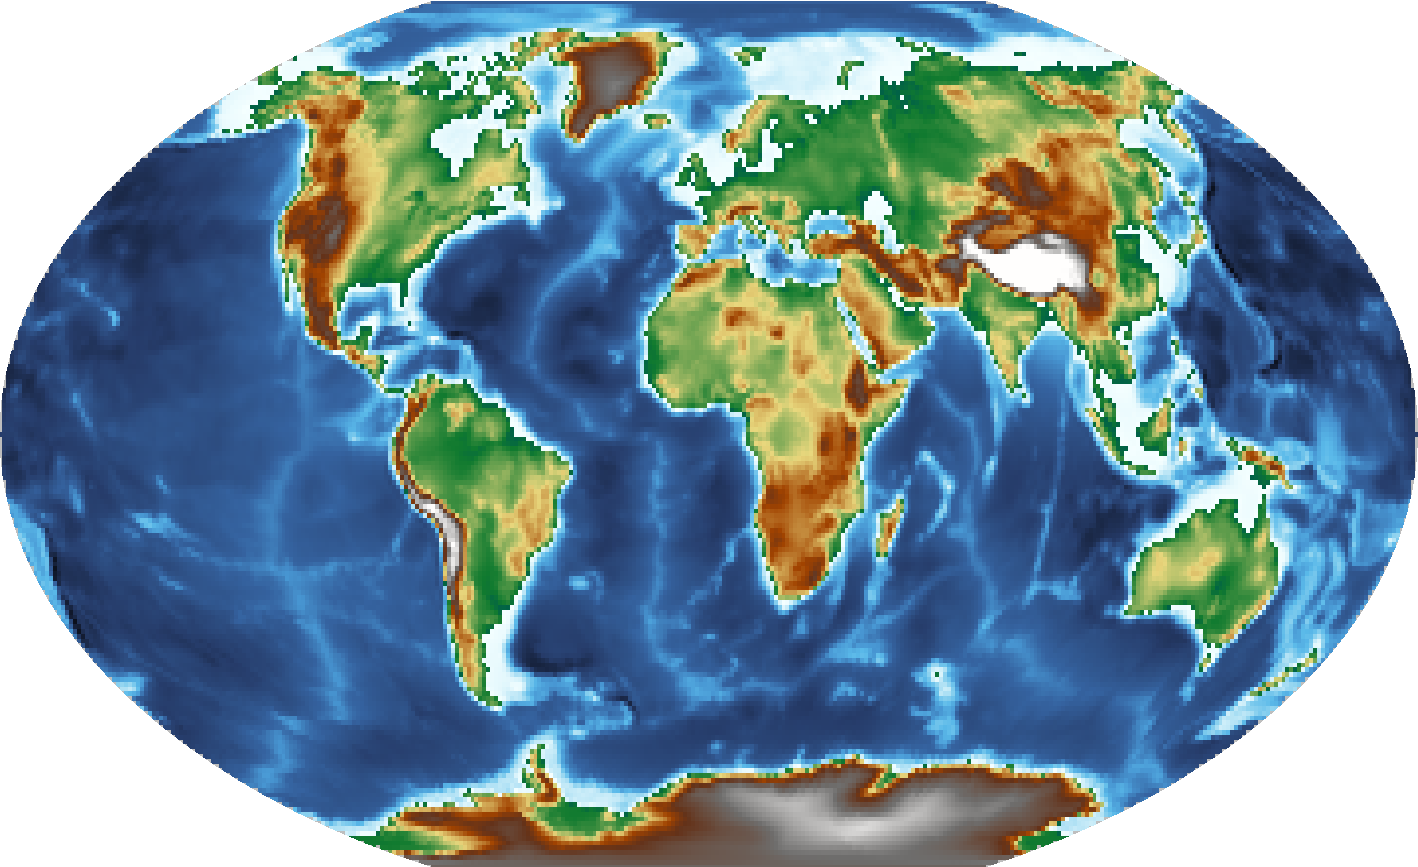

In [3]:
fig = pygmt.Figure()
fig.grdimage(grid=grid, projection="R12c", cmap="geo")
fig.show()

## Processing raster data

All of the PyGMT raster processing modules can accept and return Xarray DataArrays. As one example, we'll use the `grdgradient` function to create a hillshade raster. This will calculate the reflection of a light source projecting from west to east at an altitude of 30 degrees.

In [4]:
region = [-119.825, -119.4, 37.6, 37.825]
grid = pygmt.datasets.load_earth_relief(resolution="03s", region=region)

hillshade = pygmt.grdgradient(grid=grid, radiance=[270, 30])
hillshade

<xarray.DataArray 'z' (lat: 271, lon: 511)> Size: 1MB
array([[-0.30839247, -0.37808514, -0.30799666, ...,  0.12039052,
         0.20474193, -0.17929687],
       [-0.09469072, -0.3017121 , -0.31324536, ...,  0.0442035 ,
         0.06209851, -0.07466871],
       [-0.95000005, -0.95000005, -0.26423818, ...,  0.04321925,
         0.03116445,  0.13370842],
       ...,
       [-0.44154865, -0.31297821, -0.20481637, ..., -0.1700097 ,
        -0.22448991, -0.25389677],
       [-0.74398577, -0.27561006, -0.31929246, ..., -0.1227859 ,
        -0.1983598 , -0.20921303],
       [-0.42644808, -0.35136998, -0.39577812, ..., -0.04772562,
        -0.19724692, -0.21158722]])
Coordinates:
  * lat      (lat) float64 2kB 37.6 37.6 37.6 37.6 ... 37.82 37.82 37.82 37.83
  * lon      (lon) float64 4kB -119.8 -119.8 -119.8 ... -119.4 -119.4 -119.4
Attributes:
    Conventions:   CF-1.7
    title:         Produced by grdgradient
    history:       gmt grdgradient @GMTAPI@-S-I-G-M-G-N-000000 -E270/30 -G@GM...
    description:   Lambertian radiance
    long_name:     z
    actual_range:  [ 508. 3533.]

Let's plot the result using the same grdimage function shared earlier, this time using a custom colormap.

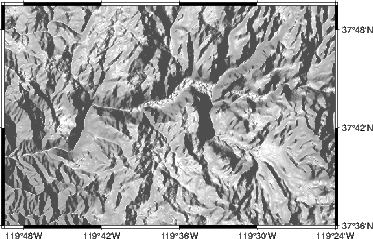

In [5]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="gray", series=[-1.5, 0.3, 0.01])
fig.grdimage(
    grid=hillshade,
    projection="M12c",
    frame=["lSEt", "xa0.1", "ya0.1"],
    cmap=True,
)
fig

## Download data and load with Xarray

Most times you'll want to use your own data rather than the sample datasets. Here we show how to use the `which` functionality to download a NetCDF file available via https.

In [6]:
# Download the dataset from the IRI Data Library
url = "https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Grid-1x1/.Annual/.temperature/.t_an/data.nc"
netcdf_file = pygmt.which(fname=url, download=True)
woa_temp = xr.open_dataset(netcdf_file).isel(time=0)
woa_temp

<xarray.Dataset> Size: 9MB
Dimensions:  (lat: 180, depth: 33, lon: 360)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * depth    (depth) float32 132B 0.0 10.0 20.0 30.0 ... 4.5e+03 5e+03 5.5e+03
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    time     datetime64[ns] 8B 2008-01-01
Data variables:
    t_an     (depth, lat, lon) float32 9MB ...

grdinfo [WARNING]: No 3-D array in file /Users/max/Documents/Code/genericmappingtools/agu24workshop/book/data.nc.  Selecting first 3-D slice in the 4-D array t_an


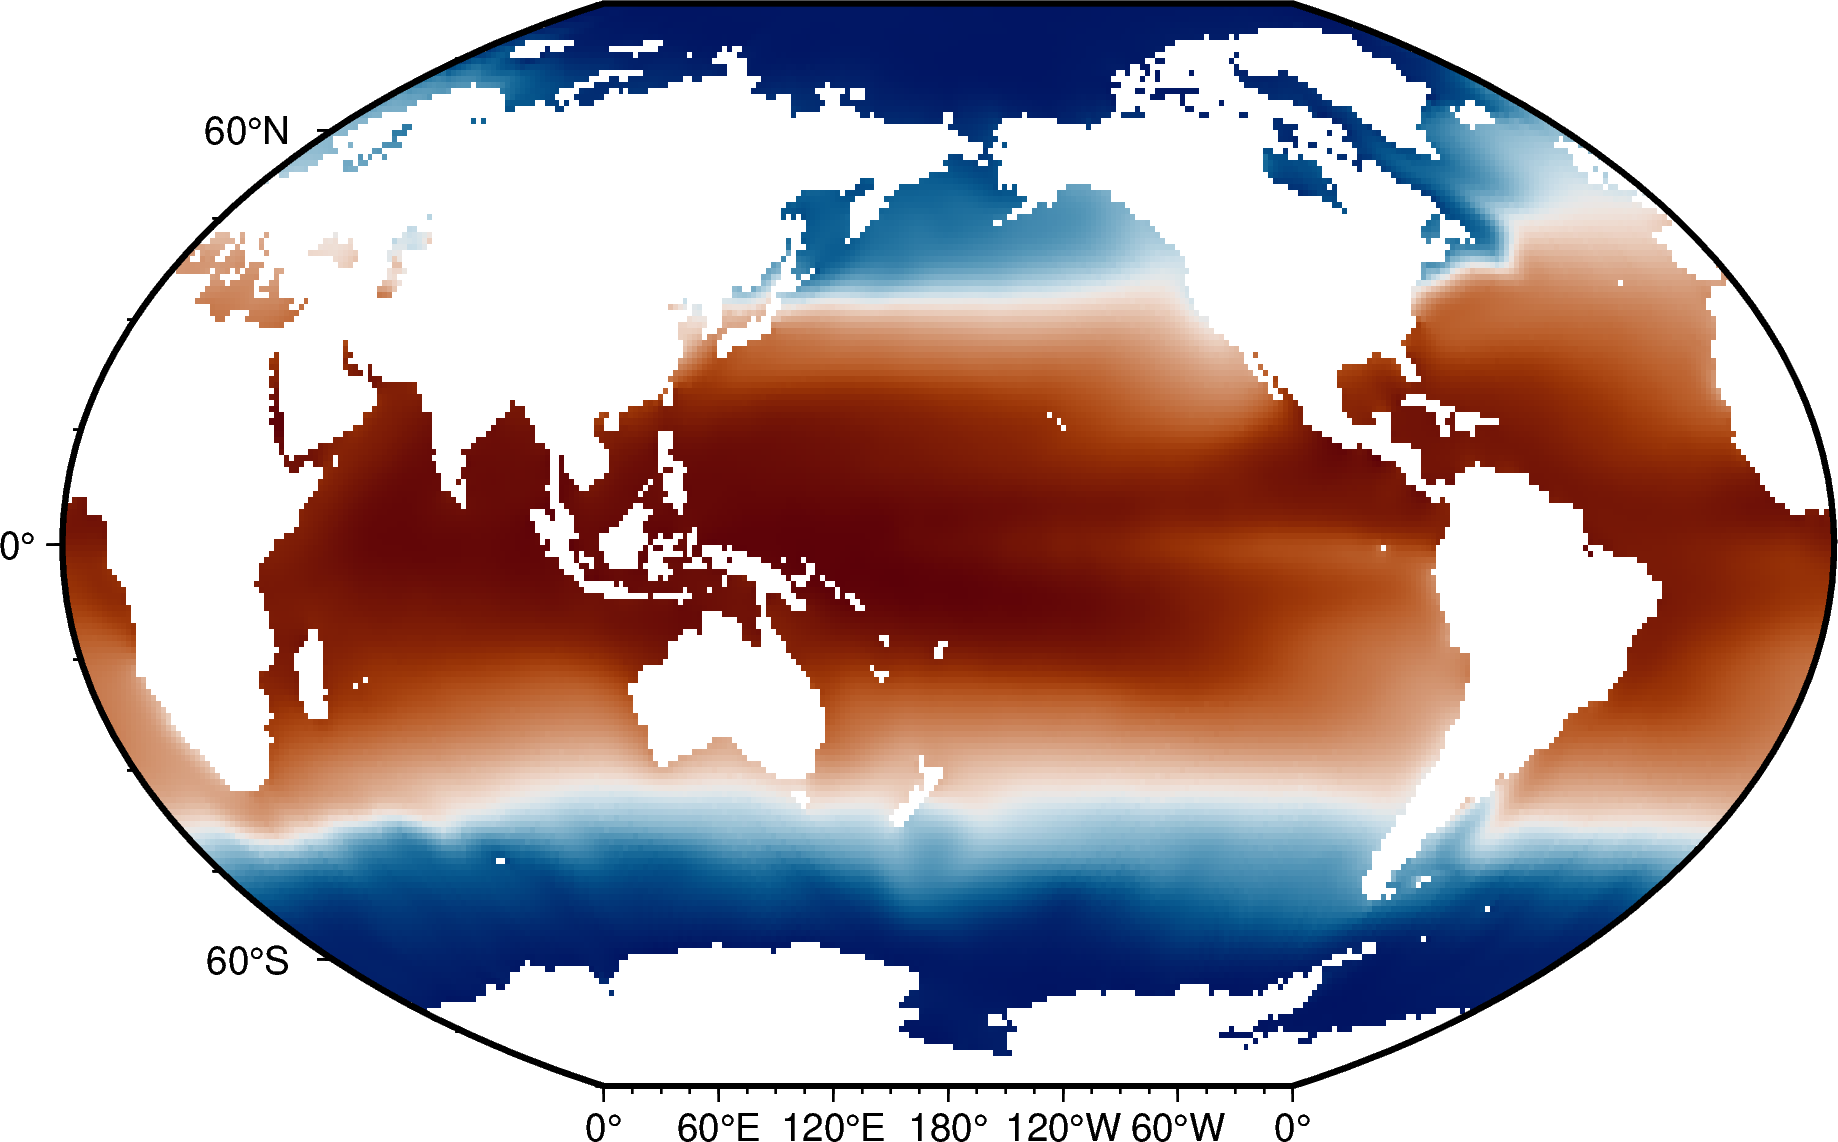

In [7]:
# Make a static plot of sea surface temperature
fig = pygmt.Figure()
fig.grdimage(grid=woa_temp.t_an.sel(depth=0), cmap="vik", projection="R15c", frame=True)
fig.show()

## Open data directly from the cloud

Xarray allows you to open data directly from cloud object storage. This can be useful to avoid downloading the entire dataset, since Xarray can subset to a specific section of interest before loading the data into memory.

Here we show this functionality based on [Xarray's tutorial](https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html#selecting-time-slices). We'll load a specific dataset from the Coupled Model Intercomparison Project Phase 6 (CMIP6), calculate the sea level change between 2015 and 2100, and plot the results using PyGMT.

Load CMIP6 data from Google Cloud Storage

In [8]:
fs = gcsfs.GCSFileSystem(token="anon")

store = fs.get_mapper(
    "gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Omon/zos/gr/v20180701/"
)
ds = xr.open_zarr(store=store, consolidated=True)
ds

<xarray.Dataset> Size: 268MB
Dimensions:    (lat: 180, bnds: 2, lon: 360, time: 1032)
Coordinates:
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 3kB ...
  * lon        (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
    lon_bnds   (lon, bnds) float64 6kB ...
  * time       (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object 17kB ...
Dimensions without coordinates: bnds
Data variables:
    zos        (time, lat, lon) float32 267MB ...
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    tracking_id:            hdl:21.14100/21c772eb-064e-4c75-8e16-da95bbfd29b7...
    variable_id:            zos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/21c772eb-064e-4c75-8e16-da95bbfd29b7...
    version_id:             v20180701

Calculate the different in sea level between a date in 2100 and 2015

In [9]:
zos_2015jan = ds.zos.sel(time="2015-01-16").squeeze()
zos_2100dec = ds.zos.sel(time="2100-12-16").squeeze()
sealevelchange = zos_2100dec - zos_2015jan.load()

Make a plot of the difference in sea level

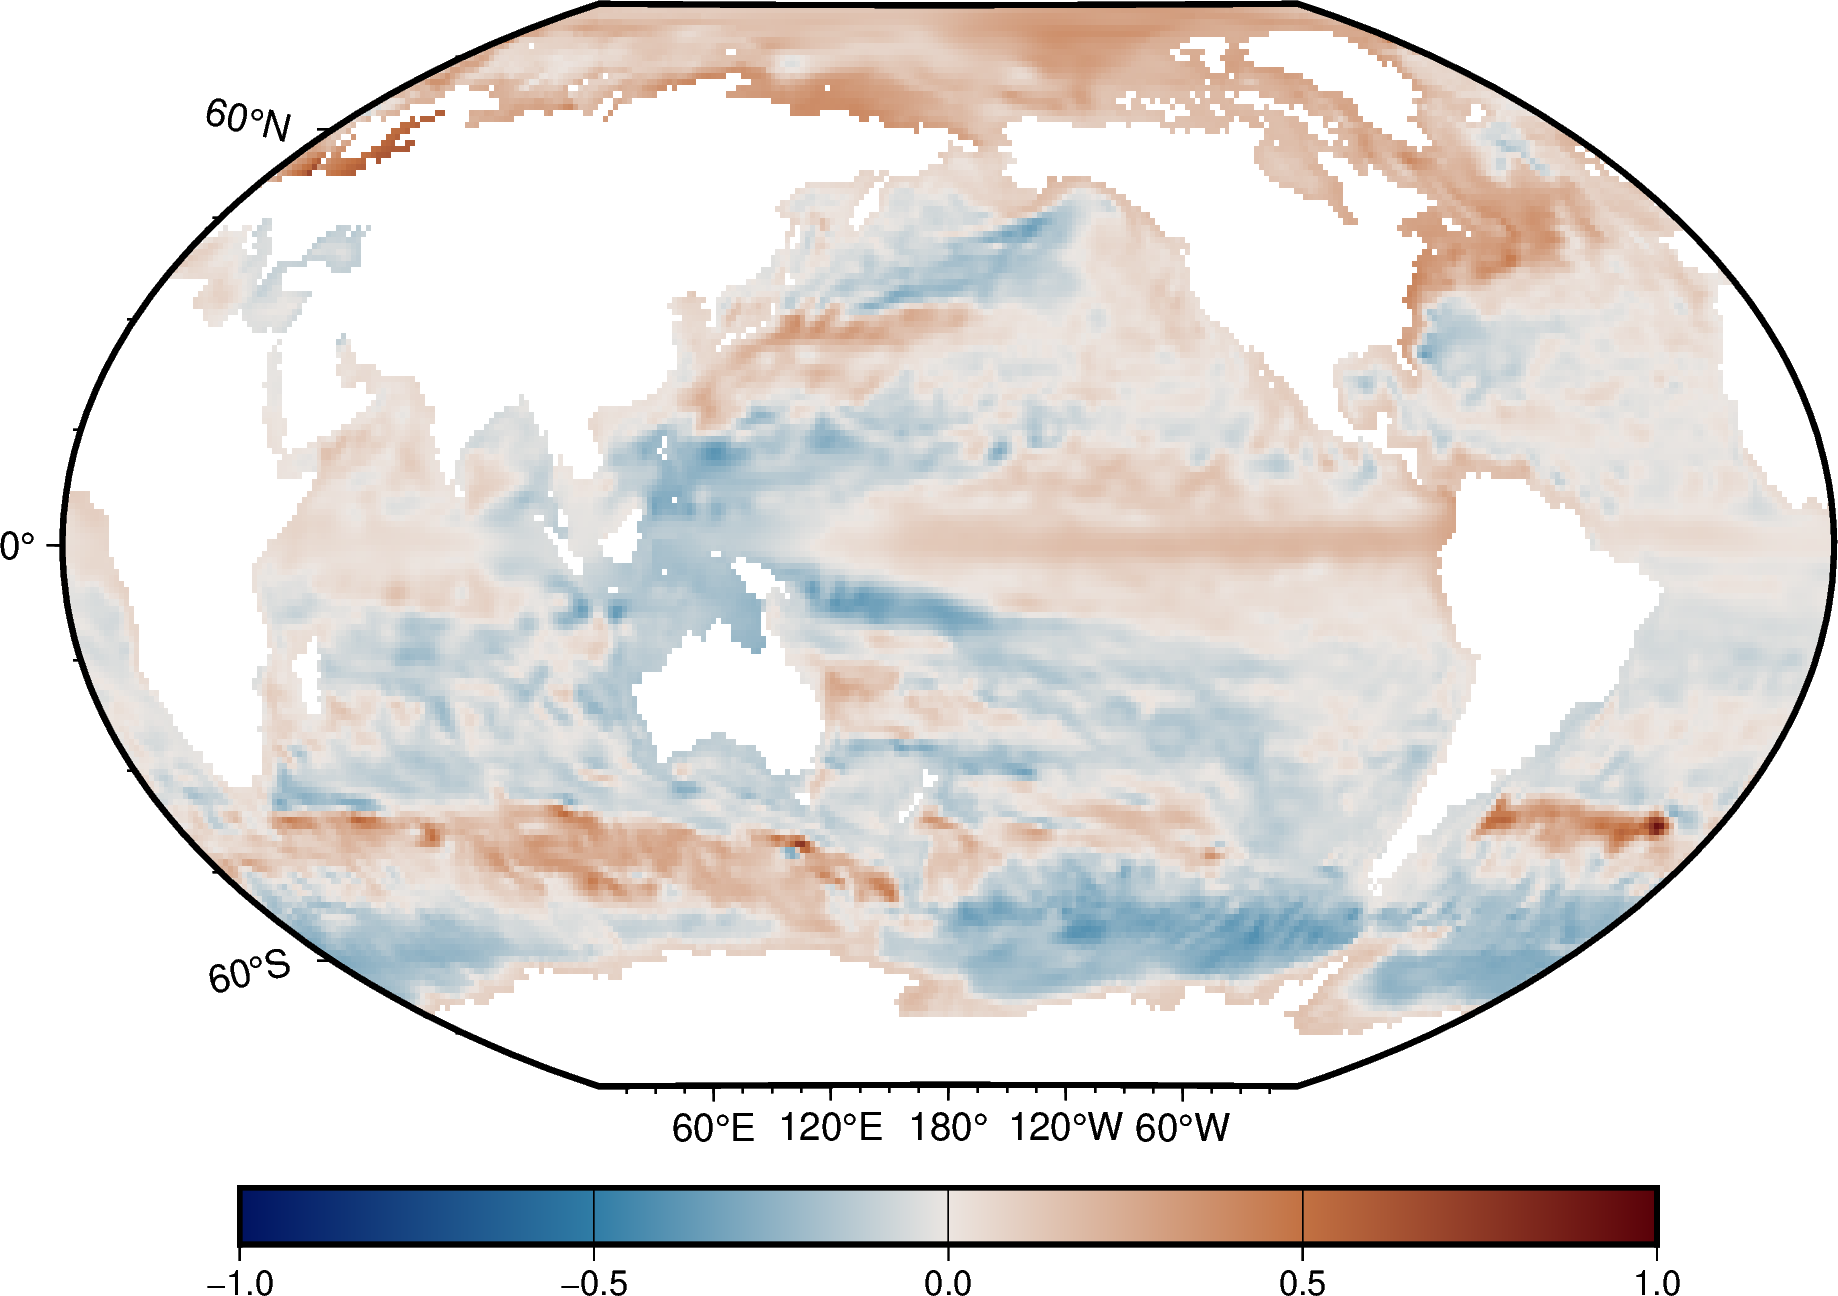

In [10]:
fig = pygmt.Figure()
pygmt.makecpt(cmap="vik", series=[-1, 1, 0.5], continuous=True)
fig.grdimage(grid=sealevelchange, cmap=True, projection="R15c", frame=True)
fig.colorbar()
fig.show()